# Load Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt



# Load File

# Dataset Split

In [2]:
def load_raw_data():
    useID = False
    if useID:
        X_train = pd.read_csv('../clean_data/X_train.csv', index_col=None)
        y_train = pd.read_csv('../clean_data/y_train.csv', index_col=None)
        X_pred  = pd.read_csv('../clean_data/X_test.csv', index_col=None)    
    else:
        X_train = pd.read_csv('../clean_data/X_train.csv', index_col='ID')
        y_train = pd.read_csv('../clean_data/y_train.csv', index_col='ID')
        X_pred  = pd.read_csv('../clean_data/X_test.csv', index_col='ID')
    
    return X_train, y_train, X_pred



# Data Preprocessing

In [3]:
#Brand
def basic_preprocessing(X, basic_only=False):
    X["brand"] = X["brand"].str.strip()
    X['brand'] = X['brand'].str.replace('M', 'm')
    X['brand'] = X['brand'].str.replace('marca', '')
    X["brand"] = X["brand"].str.strip()

    #SKU is an ID - therefore categorical not a "real" number
    X['sku'] = X['sku'].apply(lambda x: str(x))
    
    
    X[['new_pvp', 'discount']] = X['new_pvp (discount)'].str.split(' ', expand=True)
    X.drop(['new_pvp (discount)'], axis=1, inplace=True)

    X['oldpvp']     = X['oldpvp'].apply(lambda x: str(x).replace(',', '.'))
    #Prices should be numbers
    X['oldpvp']     = X['oldpvp'].apply(lambda x: float(x))

   
    X['new_pvp']    = X['new_pvp'].apply(lambda x: str(x).replace(',', '.'))
    #Prices should be numbers
    X['new_pvp']    = X['new_pvp'].apply(lambda x: float(x))


    X['discount'] = X['discount'].apply(lambda x: str(x).replace('%', ''))
    X['discount'] = X['discount'].apply(lambda x: str(x).replace('(', ''))
    X['discount'] = X['discount'].apply(lambda x: str(x).replace(')', ''))
    X['discount'] = X['discount'].apply(lambda x: '0.'+x if len(x) == 2 else x)

    X['discount'] = X['discount'].apply(lambda x: float(x))
    X["discount"] = X["discount"].apply(lambda x: x if x <= 1.0 else x / 100)

    #Weight should be a number - but I'm not sure how useful it is...
    X['weight (g)'] = X['weight (g)'].apply(lambda x: str(x).replace(' ', ''))
    most_frequ_weight = X['weight (g)'].mode()
    most_frequ_weight = most_frequ_weight[0]

    X['weight (g)'] = X['weight (g)'].apply(lambda x: int(x) if x != '' and x != 'nan' else int(most_frequ_weight))


    X['expiring_date'] = X['expiring_date'].apply(lambda x: str(x).replace('/', '-'))
    X['labelling_date'] = X['labelling_date'].apply(lambda x: str(x).replace('/', '-'))
    
    
    X['expiring_date'] = pd.to_datetime(X['expiring_date'], format='%d-%m-%Y')
    X['expiring_day'] = X['expiring_date'].dt.dayofweek
    X['expiring_day'] = X['expiring_day'].astype(str)

    X["idstore"] = X["idstore"].apply(str)       

    X['labelling_date'] = pd.to_datetime(X['labelling_date'], format='mixed')
    X["labelling_day"] = X["labelling_date"].dt.dayofweek  
    X["labelling_day"] = X["labelling_day"].astype(str)


    X['duration_days'] = pd.to_datetime(X['expiring_date']) - pd.to_datetime(X['labelling_date'])
    X['duration_days'] =  X['duration_days'].dt.total_seconds() / (24 * 60 * 60)

    # calculate total cost from profit and margin
    X_cost = ((100 - X['Margin (%)'].to_numpy()) / X['Margin (%)'].to_numpy()) * X['Profit (€)'].to_numpy()
    X.loc[:, ('Cost (€)')] = X_cost

    X.drop(['labelqty'], axis=1, inplace=True)
    X.drop(['labelling_date'], axis=1, inplace=True)
    X.drop(['expiring_date'], axis=1, inplace=True)
    
    #Which one of these buggers is now irrelevent?
    #X.drop(['new_pvp', 'oldpvp'], axis=1, inplace=True)

    X.drop(['Margin (%)'], axis=1, inplace=True)
    
    return X


In [4]:
#original data
X_train, y, X_test = load_raw_data()

X_train = basic_preprocessing(X_train, basic_only=False)
X_test = basic_preprocessing(X_test, basic_only=False)
X_train.describe()

,oldpvp,weight (g),Profit (€),perc_expiring_sku,new_pvp,discount,duration_days,Cost (€)
count,104943.000000,104958.000000,104958.000000,104865.000000,104938.000000,104938.000000,104958.000000,104958.000000
mean,1.576960,163.221870,0.174245,0.385658,1.097085,0.302237,1.479649,0.920495
std,1.647254,57.659202,0.075933,0.223632,0.863733,0.036686,1.295627,0.331076
min,0.590000,2.000000,0.034000,0.000000,0.340000,0.030000,0.000000,0.282200
25%,1.190000,122.250000,0.124500,0.200000,0.830000,0.300000,1.000000,0.680600
50%,1.590000,166.000000,0.152900,0.333333,1.110000,0.300000,1.000000,0.910200
75%,1.890000,192.000000,0.222400,0.666667,1.320000,0.300000,2.000000,1.112000
max,500.000000,410.000000,1.438400,2.000000,250.000000,0.510000,25.000000,7.551600


In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104958 entries, 110075 to 121977
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   idstore            104958 non-null  object 
 1   sku                104958 non-null  object 
 2   brand              104958 non-null  object 
 3   oldpvp             104943 non-null  float64
 4   weight (g)         104958 non-null  int64  
 5   Profit (€)         104958 non-null  float64
 6   perc_expiring_sku  104865 non-null  float64
 7   new_pvp            104938 non-null  float64
 8   discount           104938 non-null  float64
 9   expiring_day       104958 non-null  object 
 10  labelling_day      104958 non-null  object 
 11  duration_days      104958 non-null  float64
 12  Cost (€)           104958 non-null  float64
dtypes: float64(7), int64(1), object(5)
memory usage: 11.2+ MB


In [6]:
X_train["brand"].unique()

array(['2', '7', '26', '15', '12', '5', '33', '3', '25', '9', '8', '21',
       '16', '28', '13', '22', '6', '23', '20', '40', '4', '17', '41',
       '18', '36', '24', '29', '27', '10', '1', '32', '19', '42', '31',
       '37', '39', '14', '11', '38', '34'], dtype=object)

array([[<Axes: title={'center': 'oldpvp'}>,
        <Axes: title={'center': 'weight (g)'}>,
        <Axes: title={'center': 'Profit (€)'}>],
       [<Axes: title={'center': 'perc_expiring_sku'}>,
        <Axes: title={'center': 'new_pvp'}>,
        <Axes: title={'center': 'discount'}>],
       [<Axes: title={'center': 'duration_days'}>,
        <Axes: title={'center': 'Cost (€)'}>, <Axes: >]], dtype=object)

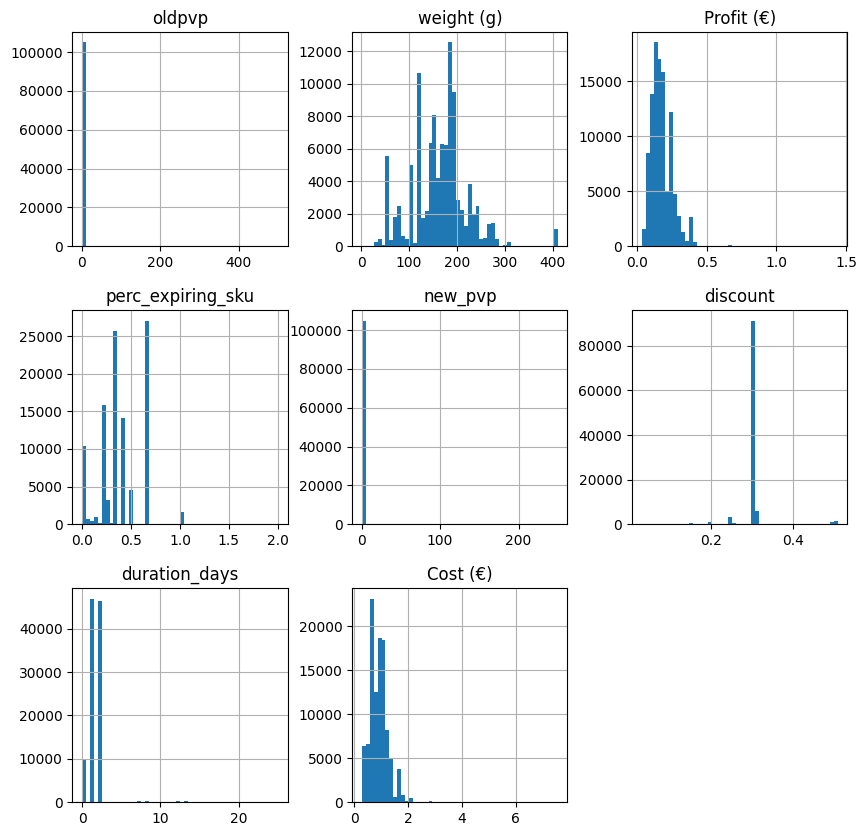

In [6]:
numerical_columns = X_train.select_dtypes(include='number').columns.tolist()
X_train[numerical_columns].hist(bins=50, figsize=(10,10))



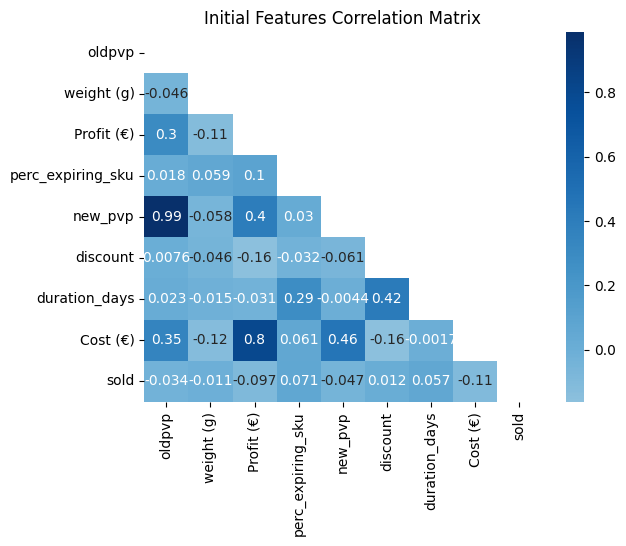

In [7]:
#Now perform an initial transformation pipeline

complete_best_data = pd.concat([X_train, y], axis=1)
import matplotlib.pyplot as plt
import seaborn as sns

numerical_features = complete_best_data.select_dtypes(include='number').columns.tolist()
correlation_matrix = complete_best_data[numerical_features].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, cmap='Blues', center=0, annot=True, mask=mask)
plt.title('Initial Features Correlation Matrix')
plt.show()

In [8]:
def drop_high_corrs(X_tr, X_ts):
    X_tr.drop(['new_pvp'], axis=1, inplace=True)
    X_ts.drop(['new_pvp'], axis=1, inplace=True)
   
    X_tr.drop(['oldpvp'], axis=1, inplace=True)
    X_ts.drop(['oldpvp'], axis=1, inplace=True)
   
    X_tr.drop(['Cost (€)'], axis=1, inplace=True)
    X_ts.drop(['Cost (€)'], axis=1, inplace=True)

    return X_tr, X_ts

In [9]:
def get_estimator(est):
    estimator = None

    match est:
        case "sgd":
            estimator = SGDClassifier(max_iter=10000, tol=1e-3)
        case "tree":
            estimator = DecisionTreeClassifier(random_state=0)
        case "forest":
            estimator = RandomForestClassifier(random_state=0, n_jobs=-1)#speedy up
        case "xgboost":
            estimator = XGBClassifier(random_state=0)
        case "knn":
            estimator = KNeighborsClassifier()
    return estimator

In [10]:
def default_pipeline_process(estimator, X_train_s, y_s):
    numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scale', MinMaxScaler())
    ])

    categorical_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('one-hot', OneHotEncoder(handle_unknown='ignore'))
    ])

    numerical_features = X_train_s.select_dtypes(include='number').columns.tolist()
    categorical_features = X_train_s.select_dtypes(include='object').columns.tolist()

    full_processor = ColumnTransformer(transformers=[
        ('number', numeric_pipeline, numerical_features),
        ('category', categorical_pipeline, categorical_features)
    ])    

    proc_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', estimator)    
        ])
    clf = proc_pipeline.fit(X_train_s, y_s['sold'])
    return clf

In [11]:
def performance_pipeline_process(estimator, X_train_s, y_s):
    numeric_pipeline = Pipeline(steps=[
    ('impute', KNNImputer(n_neighbors=5)),
    ('transform', PowerTransformer(method='yeo-johnson', standardize=False)),
    ('scale', MinMaxScaler())
    ])

    categorical_pipeline = Pipeline(steps=[
        ('impute', KNNImputer(n_neighbors=5)),
        ('one-hot', OneHotEncoder(handle_unknown='ignore'))
    ])

    numerical_features = X_train_s.select_dtypes(include='number').columns.tolist()
    categorical_features = X_train_s.select_dtypes(include='object').columns.tolist()

    full_processor = ColumnTransformer(transformers=[
        ('number', numeric_pipeline, numerical_features),
        ('category', categorical_pipeline, categorical_features)
    ])    

    proc_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', estimator)    
        ])
    X_train, X_test, y_train, y_test = train_test_split(X_train_s, y_s, test_size=0.2, random_state=0)
    clf = proc_pipeline.fit(X_train, y_train['sold'])
    y_pred = clf.predict(X_test)
    print(classification_report(y_test['sold'], y_pred))
    return clf

In [12]:
X_train, y, X_test = load_raw_data()

X_train     = basic_preprocessing(X_train)
X_test      = basic_preprocessing(X_test)

drop_high_corrs(X_train, X_test)
X_train.info()

    
estimator   = get_estimator("forest")

X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y, test_size=0.2, random_state=0)

clf = performance_pipeline_process(estimator, X_train_split, y_train_split)
    


<class 'pandas.core.frame.DataFrame'>
Index: 104958 entries, 110075 to 121977
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   idstore            104958 non-null  object 
 1   sku                104958 non-null  object 
 2   brand              104958 non-null  object 
 3   weight (g)         104958 non-null  int64  
 4   Profit (€)         104958 non-null  float64
 5   perc_expiring_sku  104865 non-null  float64
 6   discount           104938 non-null  float64
 7   expiring_day       104958 non-null  object 
 8   labelling_day      104958 non-null  object 
 9   duration_days      104958 non-null  float64
dtypes: float64(4), int64(1), object(5)
memory usage: 8.8+ MB
              precision    recall  f1-score   support

         0.0       0.69      0.69      0.69      7753
         1.0       0.73      0.73      0.73      9041

    accuracy                           0.71     16794
   macro avg       0.

Train score: 0.819093442583903
Test score: 0.7127477134146342


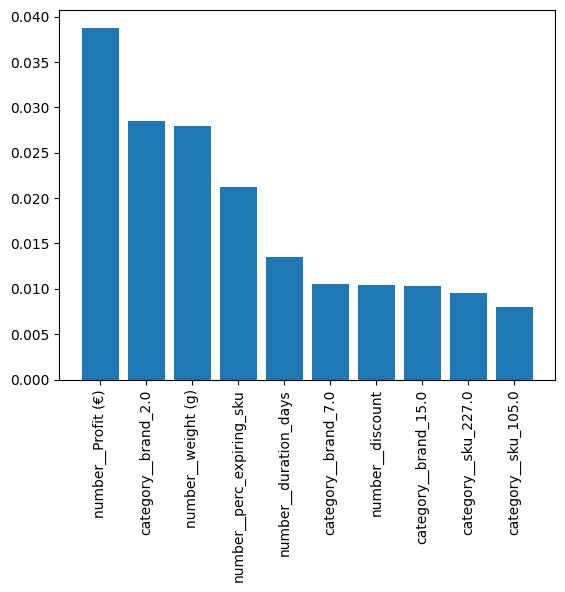

In [13]:
train_score =  clf.score(X_train_split, y_train_split[['sold']])
print(f"Train score: {train_score}")

test_score  =  clf.score(X_test_split, y_test_split[['sold']])
print(f"Test score: {test_score}")

importance          = clf['model'].feature_importances_.argsort()[::-1][0:10]
importance_values   = clf['model'].feature_importances_[importance]
features            = clf['preprocess'].get_feature_names_out()[importance]

# summarize feature importance
#for i,v in enumerate(importance):
#    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance

plt.bar(features, importance_values)
plt.xticks(rotation=90)
plt.show()
#drop_high_corrs()


In [118]:
import joblib


def save_model(clf, name):
    joblib.dump(clf, f'../models/{name}.joblib')

def load_model(name):
    return joblib.load(f'../models/{name}.joblib')


save_model(clf, "forest_model")

In [14]:
y_pred = clf.predict(X_test_split)
report = classification_report(y_test_split[['sold']], y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.69      0.69      0.69      9750
         1.0       0.73      0.73      0.73     11242

    accuracy                           0.71     20992
   macro avg       0.71      0.71      0.71     20992
weighted avg       0.71      0.71      0.71     20992



In [15]:
est = "forest"
best = True
y_actual_pred = clf.predict(X_test)
pred_df = pd.DataFrame(y_actual_pred.astype(int), columns=['sold'], index=X_test.index)
pred_df.to_csv('../results/y_test_' + est + '_performance_pipe.csv') 


In [13]:
from sklearn import metrics

#X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y,random_state=42,test_size=0.3) 
#print(X_train.shape, X_test.shape)

def plot_roc_curve(clf, est, best, fold, X_test_split, y_test_split):
    metrics.RocCurveDisplay.from_estimator(clf, X_test_split, y_test_split[['sold']], name=est)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity(False Positive Rate)')
    plt.ylabel('Sensitivity(True Positive Rate)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    fig_filename = '../results/ROC_'+ est + '_best_' + str(best) + '_fold_' + str(fold) + '.png'
    plt.savefig(fig_filename)
    plt.show()
    return fig_filename

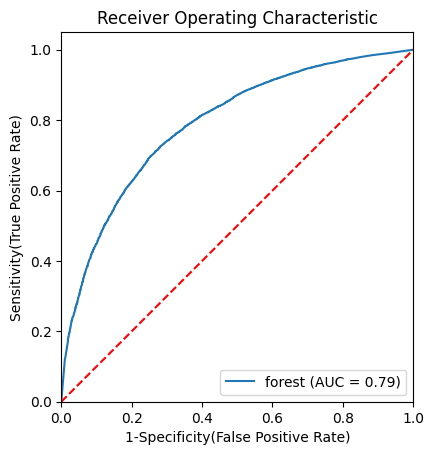

In [ ]:
plot_roc_curve(clf, est, best, 0, X_test_split, y_test_split)

In [14]:


def plot_precision_recall_curve(clf, est, best, fold, X_test_split, y_test_split):
    metrics.PrecisionRecallDisplay.from_estimator(clf, X_test_split, y_test_split[['sold']], name=est)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower right")
    fig_filename = '../results/PRC_'+ est + '_best_' + str(best) + '_fold_' + str(fold) + '.png'
    plt.savefig(fig_filename)
    plt.show()
    return fig_filename


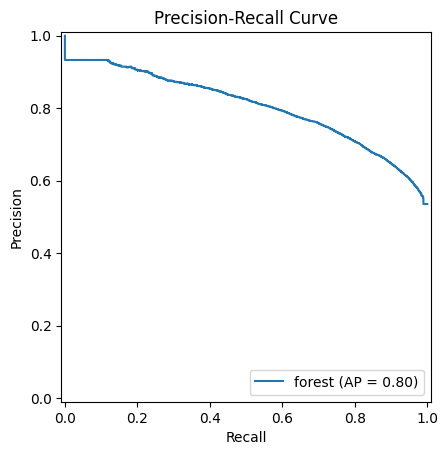

In [125]:
plot_precision_recall_curve(clf, est, best, 0, X_test_split, y_test_split)

In [126]:
#just a single model for now


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
import time

SEED = 42

def hyperparameter_tune(base_model, parameters, n_iter, kfold, X, y):
    start_time = time.time()
    
    # Arrange data into folds with approx equal proportion of classes within each fold
    k = StratifiedKFold(n_splits=kfold, shuffle=False)
    
    optimal_model = RandomizedSearchCV(base_model,
                            param_distributions=parameters,
                            n_iter=n_iter,
                            cv=k,
                            n_jobs=-1,
                            random_state=SEED)
    
    optimal_model.fit(X, y)
    
    stop_time = time.time()

    scores = cross_val_score(optimal_model, X, y, cv=k, scoring="accuracy")
    
    print("Elapsed Time:", time.strftime("%H:%M:%S", time.gmtime(stop_time - start_time)))
    print("====================")
    print("Cross Val Mean: {:.3f}, Cross Val Stdev: {:.3f}".format(scores.mean(), scores.std()))
    print("Best Score: {:.3f}".format(optimal_model.best_score_))
    print("Best Parameters: {}".format(optimal_model.best_params_))
    
    return optimal_model.best_params_, optimal_model.best_score_



In [15]:
class logger:
    def __init__(self, log_file=None):

        if log_file is None:            
            self.log = open('log.md', 'w')
        else:
            self.log = open(log_file, 'w')
        self.print_out_ = True
    
    def print_out(self, to_print):
        if self.print_out_ :
            print(to_print)

    def img(self, img_name):
        self.log.write('!['+ img_name + "](" + img_name + ')\n')

    def table(self, table):
        self.log.write(table.to_markdown() + '\n')
        self.log.write('\n')


    def code(self, code):
        self.log.write('```python\n' + code + '\n```\n')

    def title(self, title):
        self.log.write('# ' + title + '\n')
        self.print_out(title)


    def subtitle(self, subtitle):
        self.log.write('## ' + subtitle + '\n')
        self.print_out(subtitle)


    def text(self, text):
        self.log.write(text + '\n')
        self.print_out(text)
        

    def bold(self, text):
        self.log.write('**' + text + '**\n')

    def italic(self, text):
        self.log.write('*' + text + '*\n')        

    def file(self, file):
        with open(file, 'r') as f:
            self.log.write(f.read())
            self.log.write('\n')

    def link(self, link, text=""):
        if text != "":
            self.log.write('[' + text + '](' + link + ')\n')
        else:
            self.log.write('[' + link + '](' + link + ')\n')

    def footnote_link(self, link, text=""):
        if text != "":
            self.log.write('[^' + text + ']')
        else:
            self.log.write('[^' + link + ']')
            
    def footnote(self, text, link):
        self.log.write('[^' + link + ']: ' + text + '\n')

    def close(self):
        self.log.close()

# Pipeline

In [16]:
import joblib
from sklearn import metrics
from sklearn.model_selection import train_test_split
import time

#X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y,random_state=42,test_size=0.3) 
#print(X_train.shape, X_test.shape)


def run_all_default():
    
    all_est = ["sgd", "tree", "xgboost", "knn"]#ann in a bit
    all_start = time.time()
    
    log_to = logger('run_all_default_log.md')

    for est in all_est:        
    
        start_train = time.time()

        estimator = get_estimator(est)
        X_train, y, X_test = load_raw_data()
        
        X_train = basic_preprocessing(X_train)
        X_test = basic_preprocessing(X_test)
        
        drop_high_corrs(X_train, X_test)

        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y,random_state=42,test_size=0.3)
        clf = default_pipeline_process(estimator, X_train_split, y_train_split)                
        
        train_score =  clf.score(X_train_split, y_train_split[['sold']])
    
        log_to.title('Training ' + est + ' Train - Test Split Score:' + str(train_score))
        
        y_pred = clf.predict(X_train_split)
        report = classification_report(y_train_split[['sold']], y_pred)
        log_to.text(report)

        test_score = clf.score(X_test_split, y_test_split[['sold']])        
        log_to.title('Test' +  est + ' Train - Test Split Score:' + str(test_score))

        y_pred = clf.predict(X_test_split)
        report = classification_report(y_test_split[['sold']], y_pred)
        log_to.text(report)

        print(report)
       
        plot_name = plot_roc_curve(clf, est, True, 0, X_test_split, y_test_split)
        log_to.img(plot_name)

        plot_name = plot_precision_recall_curve(clf, est, True, 0, X_test_split, y_test_split)
        log_to.img(plot_name)

        joblib.dump(clf, '../models/model_' + str(0) + '_' + est +  '_defaults_preprocessed.pkl')
       
        end_train = time.time()
        log_to.bold('Training time : for = ' + est + str(end_train - start_train))
        
        
        y_actual_pred = clf.predict(X_test)
        pred_df = pd.DataFrame(y_actual_pred.astype(int), columns=['sold'], index=X_test.index)
        pred_df.to_csv('../results/y_test_' + est + '_' + '_defaults.csv') 

    log_to.bold('Total time : for = ' + est + str(time.time() - all_start))

Training sgd Train - Test Split Score:0.6620797604464407
              precision    recall  f1-score   support

         0.0       0.65      0.58      0.61     33972
         1.0       0.67      0.74      0.70     39498

    accuracy                           0.66     73470
   macro avg       0.66      0.66      0.66     73470
weighted avg       0.66      0.66      0.66     73470

Testsgd Train - Test Split Score:0.6665713922764228
              precision    recall  f1-score   support

         0.0       0.66      0.58      0.62     14586
         1.0       0.67      0.74      0.70     16902

    accuracy                           0.67     31488
   macro avg       0.67      0.66      0.66     31488
weighted avg       0.67      0.67      0.66     31488

              precision    recall  f1-score   support

         0.0       0.66      0.58      0.62     14586
         1.0       0.67      0.74      0.70     16902

    accuracy                           0.67     31488
   macro avg       

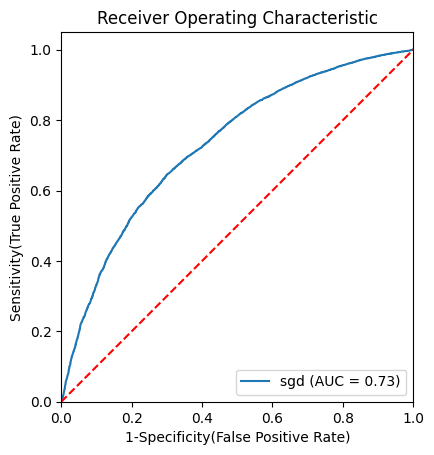

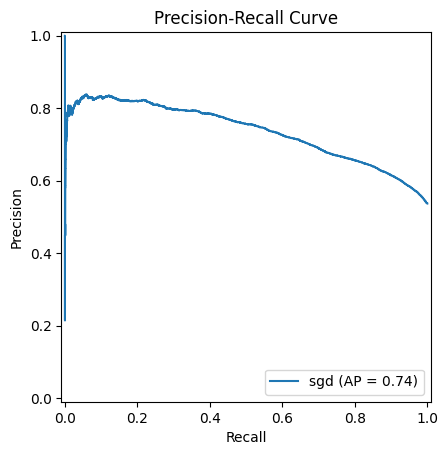

Training tree Train - Test Split Score:0.8410643800190554
              precision    recall  f1-score   support

         0.0       0.80      0.87      0.84     33972
         1.0       0.88      0.81      0.85     39498

    accuracy                           0.84     73470
   macro avg       0.84      0.84      0.84     73470
weighted avg       0.84      0.84      0.84     73470

Testtree Train - Test Split Score:0.705348069105691
              precision    recall  f1-score   support

         0.0       0.66      0.74      0.70     14586
         1.0       0.75      0.68      0.71     16902

    accuracy                           0.71     31488
   macro avg       0.71      0.71      0.71     31488
weighted avg       0.71      0.71      0.71     31488

              precision    recall  f1-score   support

         0.0       0.66      0.74      0.70     14586
         1.0       0.75      0.68      0.71     16902

    accuracy                           0.71     31488
   macro avg      

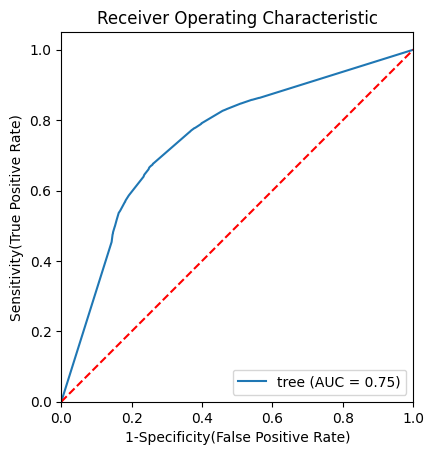

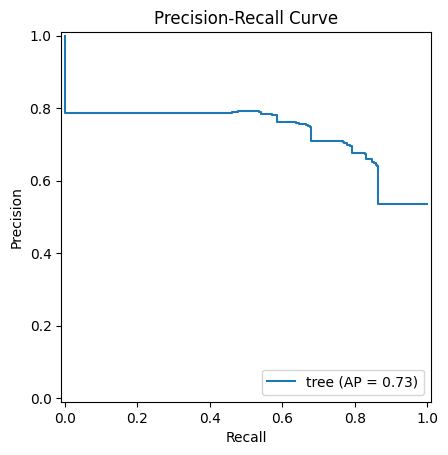

Training xgboost Train - Test Split Score:0.7106846331836124
              precision    recall  f1-score   support

         0.0       0.71      0.64      0.67     33972
         1.0       0.71      0.78      0.74     39498

    accuracy                           0.71     73470
   macro avg       0.71      0.71      0.71     73470
weighted avg       0.71      0.71      0.71     73470

Testxgboost Train - Test Split Score:0.6925495426829268
              precision    recall  f1-score   support

         0.0       0.68      0.62      0.65     14586
         1.0       0.70      0.75      0.72     16902

    accuracy                           0.69     31488
   macro avg       0.69      0.69      0.69     31488
weighted avg       0.69      0.69      0.69     31488

              precision    recall  f1-score   support

         0.0       0.68      0.62      0.65     14586
         1.0       0.70      0.75      0.72     16902

    accuracy                           0.69     31488
   macro av

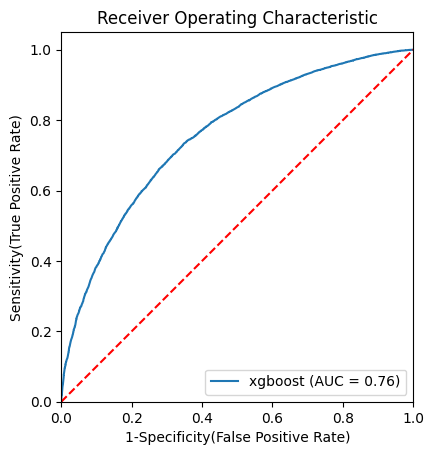

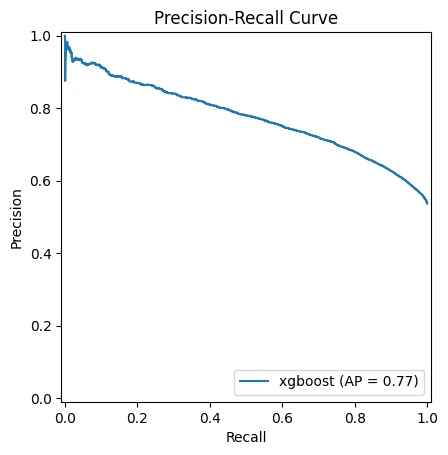

Training knn Train - Test Split Score:0.7810807132162787
              precision    recall  f1-score   support

         0.0       0.76      0.77      0.77     33972
         1.0       0.80      0.79      0.79     39498

    accuracy                           0.78     73470
   macro avg       0.78      0.78      0.78     73470
weighted avg       0.78      0.78      0.78     73470

Testknn Train - Test Split Score:0.6881986788617886
              precision    recall  f1-score   support

         0.0       0.66      0.68      0.67     14586
         1.0       0.71      0.70      0.71     16902

    accuracy                           0.69     31488
   macro avg       0.69      0.69      0.69     31488
weighted avg       0.69      0.69      0.69     31488

              precision    recall  f1-score   support

         0.0       0.66      0.68      0.67     14586
         1.0       0.71      0.70      0.71     16902

    accuracy                           0.69     31488
   macro avg       

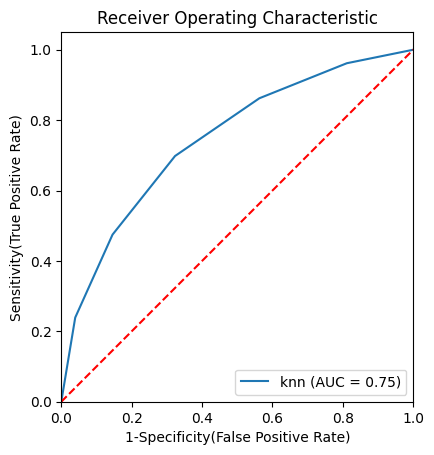

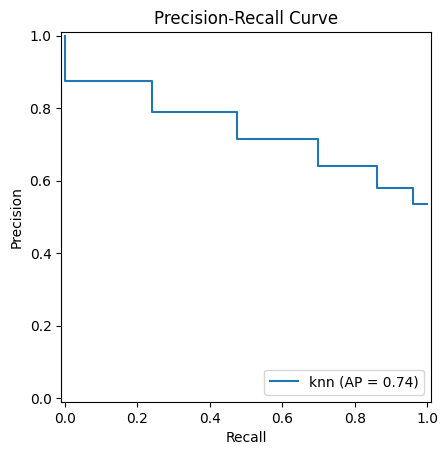

In [17]:
run_all_default()

cat ['idstore', 'brand', 'expiring_day', 'labelling_day']
num ['sku', 'Margin (%)', 'Profit (€)', 'perc_expiring_sku', 'discount', 'duration_days']
Elapsed Time: 00:04:29
Cross Val Mean: 0.698, Cross Val Stdev: 0.002
Best Score: 0.698
Best Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 2, 'min_samples_leaf': 1, 'n_estimators': 300}
--------------------
{'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 2, 'min_samples_leaf': 1, 'n_estimators': 300}
--------------------
0.6982577922961752
--------------------
['idstore', 'brand', 'expiring_day', 'labelling_day']
['sku', 'Margin (%)', 'Profit (€)', 'perc_expiring_sku', 'discount', 'duration_days']
forest Test  -  Split Score: 0.8410643800190554
forest Train - Split Score: 0.7101753048780488


In [26]:
print(est + ' Train - Test Split Score:', clf.score(X_train_split, y_train_split[['sold']]))

forest Train - Test Split Score: 0.8409827140329386


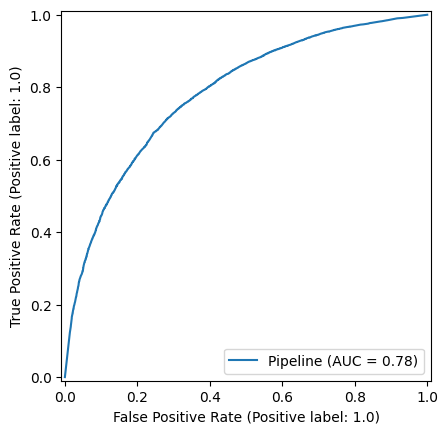

In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics
metrics.RocCurveDisplay.from_estimator(
   clf, X_test_split, y_test_split[['sold']])
plt.savefig('../results/rf_roc_curve_conv_all_2.png')
plt.show()


In [ ]:
y_actual_pred = clf.predict(X_test)
pred_df = pd.DataFrame(y_actual_pred.astype(int), columns=['sold'], index=X_test.index)
pred_df.to_csv('../results/y_test_good_' + est + '_best' + str(False) + 'defaults.csv') 

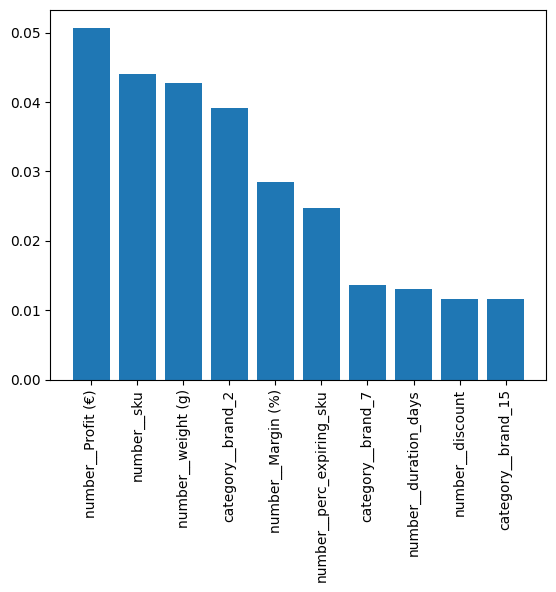

In [ ]:
importance = clf['model'].feature_importances_.argsort()[::-1][0:10]
importance_values=clf['model'].feature_importances_[importance]
features= clf['preprocess'].get_feature_names_out()[importance]

# summarize feature importance
#for i,v in enumerate(importance):
#    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
import matplotlib.pyplot as plt
plt.bar(features, importance_values)
plt.xticks(rotation=90)
plt.show()